# TechLab - Portfolio Optimization Pt.2

Nel secondo laboratorio sperimenteremo come determinare il rendimento atteso e la varianza di un portafoglio di titoli con pesi definiti a priori per poi ottimizzarli per massimizzare lo Sharpe Ratio dello stesso.

In [1]:
from pandas_datareader import data as web
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from pypfopt import CLA, plotting
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import EfficientCVaR

In [2]:
# Scelgo gli asset su cui effettuare l'ottimizzazione

assets = ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOG']

In [3]:
# Assegno quanta parte del capitale investire in ciascun asset

weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

In [4]:
# Scarico i prezzi di mercato degli asset

stockStartDate = '2020-01-01'
today = datetime.today().strftime('%Y-%m-%d')

df = pd.DataFrame()
for stock in assets:
    df[stock] = web.DataReader(stock, data_source='yahoo', start = stockStartDate, end = today)['Adj Close']

df

,FB,AMZN,AAPL,NFLX,GOOG
Date,,,,,
2020-01-02,209.779999,1898.010010,74.333511,329.809998,1367.369995
2020-01-03,208.669998,1874.969971,73.610840,325.899994,1360.660034
2020-01-06,212.600006,1902.880005,74.197395,335.829987,1394.209961
2020-01-07,213.059998,1906.859985,73.848442,330.750000,1393.339966
2020-01-08,215.220001,1891.969971,75.036385,339.260010,1404.319946
...,...,...,...,...,...
2021-02-22,260.329987,3180.739990,126.000000,533.780029,2064.879883
2021-02-23,265.859985,3194.500000,125.860001,546.150024,2070.860107
2021-02-24,264.309998,3159.530029,125.349998,553.409973,2095.169922


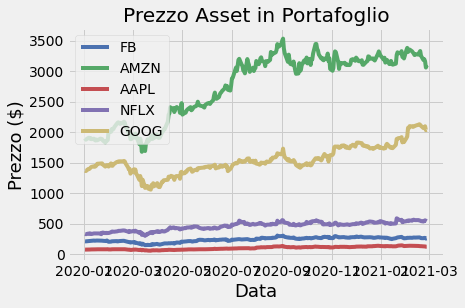

In [5]:
# Visualizzo l'andamento dei prezzi degli asset in portafoglio

title = 'Prezzo Asset in Portafoglio'
my_stocks = df

for c in my_stocks.columns.values:
    plt.plot(my_stocks[c], label =c)

plt.title(title)
plt.xlabel('Data', fontsize = 18)
plt.ylabel('Prezzo ($)', fontsize = 18)
plt.legend(my_stocks.columns.values, loc = 'upper left')
plt.show()

In [6]:
# In luogo dei prezzi, utilizziamo i simple returns

returns = expected_returns.returns_from_prices(df).dropna()
returns

,FB,AMZN,AAPL,NFLX,GOOG
Date,,,,,
2020-01-03,-0.005291,-0.012139,-0.009722,-0.011855,-0.004907
2020-01-06,0.018834,0.014886,0.007968,0.030469,0.024657
2020-01-07,0.002164,0.002092,-0.004703,-0.015127,-0.000624
2020-01-08,0.010138,-0.007809,0.016086,0.025729,0.007880
2020-01-09,0.014311,0.004799,0.021241,-0.010611,0.011044
...,...,...,...,...,...
2021-02-22,-0.004703,-0.021281,-0.029799,-0.011921,-0.017257
2021-02-23,0.021242,0.004326,-0.001111,0.023174,0.002896
2021-02-24,-0.005830,-0.010947,-0.004052,0.013293,0.011739


In [7]:
# Calcoliamo i ritorno annualizzato del portafoglio

portfolioSimpleAnnualReturn = np.sum(returns.mean() * weights) * 252
portfolioSimpleAnnualReturn

0.4503292858159998

In [8]:
# Calcolo la matrice di covarianza annualizzata per quantificare
# la variazione di ogni variabile aleatoria rispetto alle altre

cov_matrix_annual = returns.cov()*252 # NB: 252 è il numero medio di giorni di contrattazione in 1A
cov_matrix_annual # la diagonale principale esprime la varianza (σ²) annaulizzata 
                  # di ciascun asset, dove σ = volatilità

,FB,AMZN,AAPL,NFLX,GOOG
FB,0.195977,0.112028,0.151155,0.116041,0.130502
AMZN,0.112028,0.138395,0.116338,0.117784,0.093396
AAPL,0.151155,0.116338,0.202502,0.113792,0.122142
NFLX,0.116041,0.117784,0.113792,0.223674,0.094416
GOOG,0.130502,0.093396,0.122142,0.094416,0.142491


In [9]:
# Calcolo la varianza di portafoglio

port_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
port_variance

0.12952918628230717

In [10]:
# Calcolo la volatilità di portafoglio

port_volatility = np.sqrt(port_variance)
port_volatility

0.35990163417565524

In [11]:
# Rappresentiamo sinteticamente il ritorno annuo atteso, la volatilità e la varianza del potafoglio a pesi uniformi

percent_var = str(round(port_variance, 2)*100) + '%'
percent_vols = str(round(port_volatility, 2)*100) + '%'
percent_ret = str(round(portfolioSimpleAnnualReturn, 2)*100) + '%'

print('Ritorno annuo atteso: '+ percent_ret)
print('Volatilità annua: ' + percent_vols)
print('Varianza annua: ' + percent_var)

Ritorno annuo atteso: 45.0%
Volatilità annua: 36.0%
Varianza annua: 13.0%


In [12]:
# Ottimizzazione di portafoglio

# Calcoliamo ritorni attesi e matrice di covarianza annualizzata
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Ottimizziamo per massimizzare lo sharp ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose = True)

OrderedDict([('FB', 0.0), ('AMZN', 0.65192), ('AAPL', 0.16152), ('NFLX', 0.13868), ('GOOG', 0.04788)])
Expected annual return: 52.4%
Annual volatility: 35.9%
Sharpe Ratio: 1.40


(0.5237762497389362, 0.3586057598319732, 1.4048191807487518)

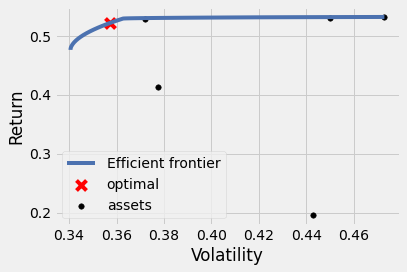

In [13]:
# Rappresentiamo la frontiera efficiente

cla = CLA(mu, S)
cla.max_sharpe()

ax = plotting.plot_efficient_frontier(cla, showfig=False)

In [14]:
# Calcolo la quantità discreta di azioni da comprare oggi rispetto al budget

latest_prices = get_latest_prices(df)
weights = cleaned_weights
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value = 15000)

allocation , leftover = da.lp_portfolio()
print('Discrete allocation:', allocation)
print('Fund remaining: ${:.2F}'.format(leftover))

Discrete allocation: {'AMZN': 3, 'AAPL': 20, 'NFLX': 4}
Fund remaining: $1140.61


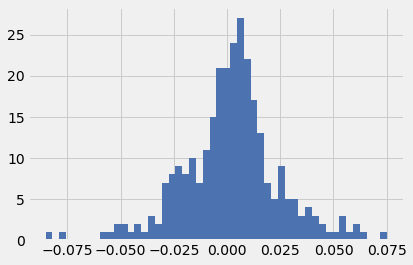

In [15]:
# Rappresentiamo la distribuzione del portafolgio
portfolio_rets = (returns * weights).sum(axis=1)
portfolio_rets.hist(bins=50);

In [16]:
# VaR e CVar del portafoglio ottimizzato per massimizzare lo Sharpe Ratio senza vincoli di rischio
var = portfolio_rets.quantile(0.05)
cvar = portfolio_rets[portfolio_rets <= var].mean()
print("VaR: {:.2f}%".format(100*var))
print("CVaR: {:.2f}%".format(100*cvar))

VaR: -3.35%
CVaR: -4.96%


In [17]:
# Nell'ipotesi di minimizzare il CVaR
ec = EfficientCVaR(mu, returns)
ec.min_cvar()
print(ec.clean_weights())
ec.portfolio_performance(verbose=True);

OrderedDict([('FB', 0.0), ('AMZN', 0.61907), ('AAPL', 0.0), ('NFLX', 0.14903), ('GOOG', 0.2319)])
Expected annual return: 50.2%
Conditional Value at Risk: 4.76%


In [18]:
# Accettando uno CVaR > di quello di portafoglio
ec = EfficientCVaR(mu, returns)
ec.efficient_risk(target_cvar=0.05)
print(ec.clean_weights())
ec.portfolio_performance(verbose=True);

OrderedDict([('FB', 0.0), ('AMZN', 0.56684), ('AAPL', 0.0277), ('NFLX', 0.40546), ('GOOG', 0.0)])
Expected annual return: 53.0%
Conditional Value at Risk: 5.00%
